## Project Three: Three Body System

### New to this version

    1. The run_odeint seems to feed the velocity of the planet before the collision to the slope function despite a new definition of the velocity when nevermores2 first becomes True. The edited slope function solves(maybe) the problem by applying the same definition of the velocity as when nevermores2 first comes True. The animation of the orbit makes sense, although it is hard to validate with physics without knowing what odeint is doing.

    2. Basic two-planet model that does not account for collision

Initial Condition
    1. Two Stationary Stars and One Body Introduced
        init_state: Star1_p = (-100, 0) v = (0, 0)
                    Star2_p = (100, 0)  v = (0, 0)
                    Planet_p = (50, 50) v = (0, -50) 
                    
        
    2. Two Stationary Stars and Two Bodies Introduced with pretty much the same condition(chaos)
    
    3. Binary Star System with Two Bodies Introduced
    
    Mass of Sun: 2 * 10^30 kg (2 kg)
    Mass of Earth: 6 * 10^24 kg (.02kg)
    G constant: 6.67*10^-11
    
   
    binary star orbits: https://en.wikipedia.org/wiki/Habitability_of_binary_star_systems
    wired article: https://www.wired.com/2016/06/way-solve-three-body-problem/
    

In [1]:
%matplotlib notebook
from modsim import *
import matplotlib.pyplot as plt
import numpy as np

<IPython.core.display.Javascript object>


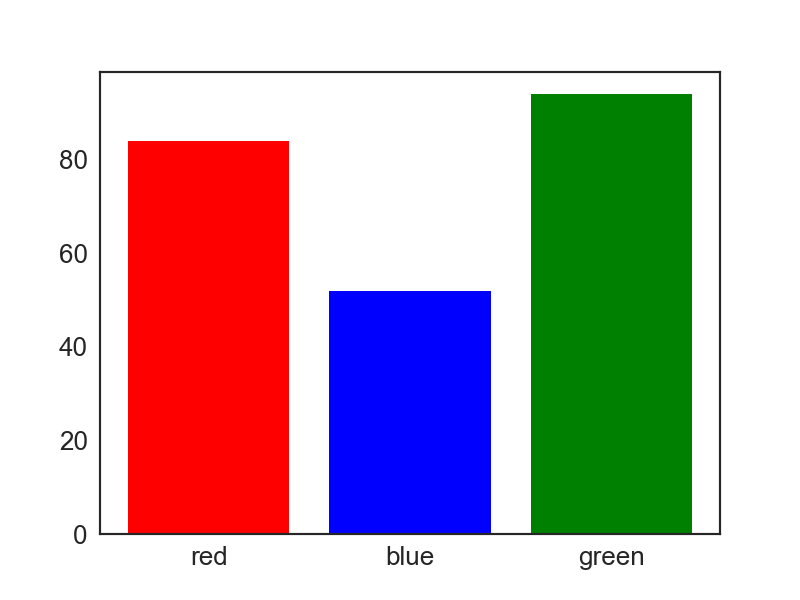

Saving figure to file bargraph.eps


In [2]:
ind = np.arange(1, 4)
height = np.random.randint(0, 100, size = 3)
figure = plt.subplot()
plt.show(block=True)
ab, cd, ef = plt.bar(ind, height)
ab.set_facecolor('r')
cd.set_facecolor('b')
ef.set_facecolor('g')
figure.set_xticks(ind)
figure.set_xticklabels(['red', 'blue', 'green'])
savefig('bargraph.eps')

In [8]:
m = UNITS.meter
s = UNITS.second
kg = UNITS.kilogram

In [16]:
condition = Condition(#m_s1 = 2,
                      m_s1 = 2 * 10**9,
                      m_s2 = 2 * 10**9,
                      m_p1 = 6*10**3, #5.95 * 10**3,
                      G = 6.67*10**-5,
                      duration = 500,
                    #Minimun dt needed for accuracy varies depending on duration
                      dt = 0.0001)

In [22]:
def make_system(condition):
    """Make a system object.
    
    condition: Condition object with angle, velocity, x, y,
               diameter, duration, g, mass, rho, and C_d
               
    returns: System object
    """
    unpack(condition)
    
    # make the initial state
    init = State(x_s1=-100, y_s1=0, x_s2=100, y_s2=0, x_p1=50, y_p1=50, vx_s1=0, vy_s1=0, vx_s2=0, vy_s2=0, vx_p1=0, vy_p1=-70)
    
    # compute timestamps
    ts = linrange(0, duration, dt)
    
    return System(init=init, G = G, m_s1 = m_s1, m_s2 = m_s2, m_p1 = m_p1, ts=ts, dt = dt, m_pnew = 0,
                  nevermores1 = 0, nevermores2 = 0)

In [23]:
system = make_system(condition)

In [32]:
def slope_func_coll(state, t, system):
    """Compute derivatives of the state.
    
    state: position, velocity
 n  m    t: time
    system: System object containing g, rho,
            C_d, area, and mass
    
    returns: derivatives of y and v
    """
    x_s1, y_s1, x_s2, y_s2, x_p1, y_p1, vx_s1, vy_s1, vx_s2, vy_s2, vx_p1, vy_p1 = state
    unpack(system)
    m_pnew = system.m_pnew
    nevermores1 = system.nevermores1
    nevermores2 = system.nevermores2
    coll = 0
    pos_p1 = Vector(x_p1, y_p1)
    v_p1 = Vector(vx_p1, vy_p1)
    pos_s1 = Vector(x_s1, y_s1)
    pos_s2 = Vector(x_s2, y_s2)

    if ((x_p1 - x_s1)**2 + (y_p1 - y_s1)**2) < (20**2):
        if nevermores1 == 0:
            print("collision between planet and sun1")
            system.nevermores1 = 1
        coll = 1
        F_p1s1 = Vector(0,0)
        F_p1s2 = Vector(0,0)
        
    else:
        if (coll == 0):
            system.nevermores1 = 0
            distance_p1s1 = pos_s1 - pos_p1
            F_p1s1 = (G * m_s1 * (m_p1 + m_pnew) / (distance_p1s1.mag**2)) * distance_p1s1.hat()
        

    if ((x_p1 - x_s2)**2 + (y_p1 - y_s2)**2) < (20**2):
        if nevermores2 == 0:
            print("collision between planet and sun2")
            system.nevermores2 = 1
        coll = 1
        F_p1s1 = Vector(0,0)
        F_p1s2 = Vector(0,0)
        
    else:
        if (coll == 0):
            system.nevermores2 = 0
            distance_p1s2 = pos_s2 - pos_p1
            F_p1s2 = (G * m_s2 * (m_p1 + m_pnew) / (distance_p1s2.mag**2)) * distance_p1s2.hat()
    
    a_p1s1 = F_p1s1 / (m_p1 + m_pnew)
    a_p1s2 = F_p1s2 / (m_p1 + m_pnew)
    a = a_p1s1 + a_p1s2
    #print(a)
    a = Vector(a)
    #print(type(a))
    
    p_present = v_p1 * (m_p1 + m_pnew)
    p_p1s1 = F_p1s1 * dt
    p_p1s2 = F_p1s2 * dt
    p_total = p_present+p_p1s1+p_p1s2
    
    v_p1 = p_total / (m_p1 + m_pnew)
    v_p1 = Vector(v_p1)
    
    #print(t, v_p1, pos_p1, m_pnew, a)
    
    #Use positions to find force acting on the planet, use the force to find momentum and acceleration, and then 
    #velocity from momentum. Return velocity and acceleration.
    
    return 0, 0, 0, 0, v_p1.x, v_p1.y, 0, 0, 0, 0, a.x, a.y

In [33]:
slope_func_coll(system.init, 0, system)

(0,
 0,
 0,
 0,
 <Quantity(0.0013803434843659547, 'dimensionless')>,
 <Quantity(-70.00205530002815, 'dimensionless')>,
 0,
 0,
 0,
 0,
 <Quantity(13.803434843659547, 'dimensionless')>,
 <Quantity(-20.553000281522934, 'dimensionless')>)

In [34]:
system = make_system(condition)
print(system.m_p1)
%time run_odeint(system, slope_func_coll)

10000000000.0
collision between planet and sun1
collision between planet and sun1
collision between planet and sun1
collision between planet and sun1
collision between planet and sun1
collision between planet and sun1
collision between planet and sun1
collision between planet and sun1
collision between planet and sun1
collision between planet and sun1
collision between planet and sun1
collision between planet and sun1
collision between planet and sun1
collision between planet and sun1
collision between planet and sun1
collision between planet and sun1
collision between planet and sun1
collision between planet and sun1
collision between planet and sun1
collision between planet and sun1
collision between planet and sun1
collision between planet and sun2
collision between planet and sun2
collision between planet and sun2
collision between planet and sun2
collision between planet and sun2
collision between planet and sun2
collision between planet and sun2
collision between planet and sun2


<IPython.core.display.Javascript object>


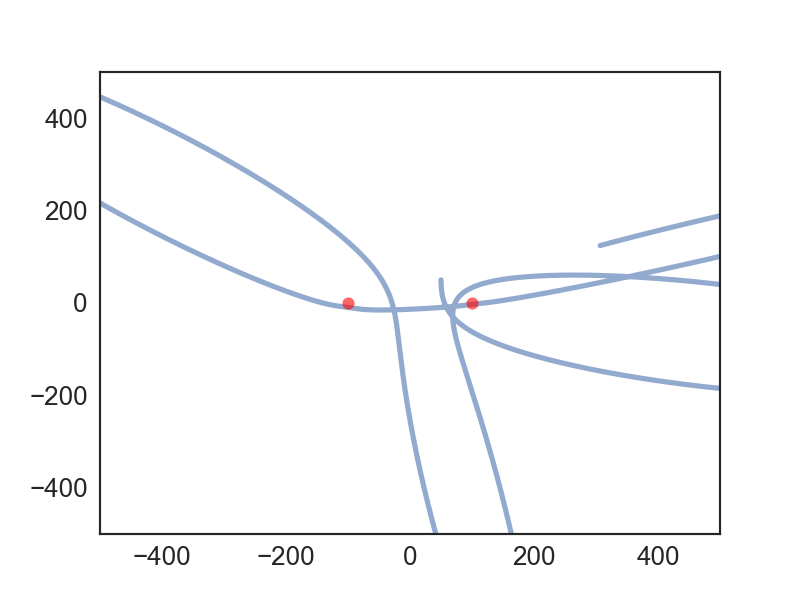

C:\ProgramData\Miniconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


In [35]:
newfig()
plot(system.results.x_p1, system.results.y_p1)
plot(-100, 0, 'ro')
plot(100, 0, 'ro')
decorate(xlim = [-500, 500],
         ylim = [-500, 500])

<IPython.core.display.Javascript object>


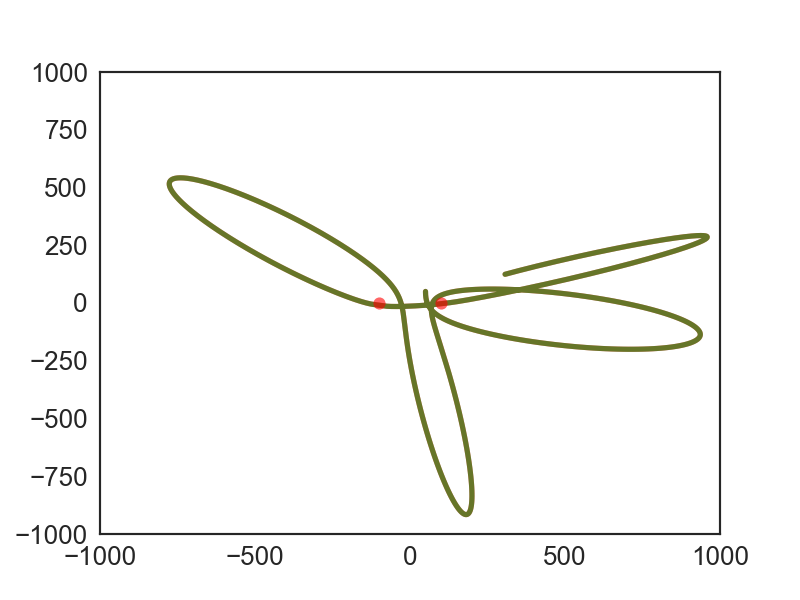

C:\ProgramData\Miniconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


In [69]:
resampled = system.results.iloc[::500, :]
newfig()
plot(resampled.x_p1, resampled.y_p1, 'r')
sleep(.5)
plot(system2.results.x_p1, system2.results.y_p1, 'g')
sleep(.5)
plot(-100, 0, 'ro')
plot(100, 0, 'ro')
decorate(xlim = [-1000, 1000],
         ylim = [-1000, 1000])

<IPython.core.display.Javascript object>


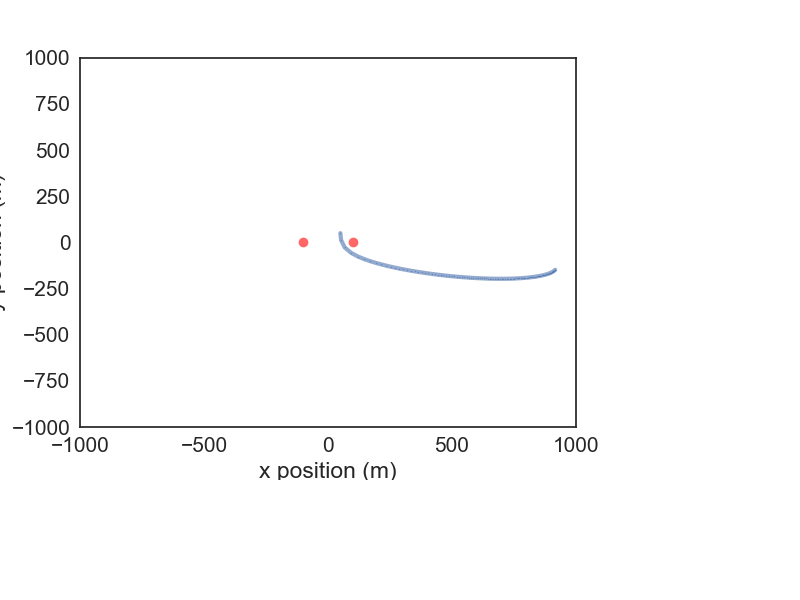

KeyboardInterrupt: 

In [32]:
newfig()
plot(-100, 0, 'ro')
plot(100, 0, 'ro')
decorate(xlabel='x position (m)',
         ylabel='y position (m)',
         xlim = [-1000, 1000],
         ylim =[-1000, 1000],
         legend=False)
x_array = []
y_array = []
for x, y in zip(resampled.x_p1, resampled.y_p1):
    x_array.append(x)
    y_array.append(y)
    plot(x_array, y_array, '-o', markersize=1, update=True)
    #plot(x, y, '-o', update=True)
    #sleep(0.00001)

## Two Planets

In [5]:
condition_2planets = Condition(m_s1 = 2 * 10**9,
                      m_s2 = 2 * 10**9,
                      m_p1 = 6 * 10**3,
                      m_p2 = 6 * 10**3,
                      G = 6.67*10**-5,
                      duration = 2500,
                    #Minimun dt needed for accuracy varies depending on duration
                      dt = 0.0001)

In [6]:
def make_system_2planets(condition):
    """Make a system object.
    
    condition: Condition object with angle, velocity, x, y,
               diameter, duration, g, mass, rho, and C_d
               
    returns: System object
    """
    unpack(condition)
    
    # make the initial state
    init = State(x_s1=-100, y_s1=0, x_s2=100, y_s2=0, x_p1=50, y_p1=50, x_p2=51, y_p2=50,
                 vx_s1=0, vy_s1=0, vx_s2=0, vy_s2=0, vx_p1=0, vy_p1=-65, vx_p2=0, vy_p2=-65)
    
    # compute timestamps
    ts = linrange(0, duration, dt)
    
    return System(init=init, G = G, m_s1 = m_s1, m_s2 = m_s2, m_p1 = m_p1, m_p2 = m_p2, ts=ts, dt = dt, m_pnew = 0,
                  nevermores1 = 0, nevermores2 = 0, nevermores3 = 0, nevermores4 = 0, metric = duration, found_metric = 0, posp1 = [], posp2 = [])

In [9]:
def slope_func_2(state, t, system):
    """Compute derivatives of the state.
    
    state: position, velocity
 n  m    t: time
    system: System object containing g, rho,
            C_d, area, and mass
    
    returns: derivatives of y and v
    """
    x_s1, y_s1, x_s2, y_s2, x_p1, y_p1, x_p2, y_p2, vx_s1, vy_s1, vx_s2, vy_s2, vx_p1, vy_p1, vx_p2, vy_p2 = state
    unpack(system)
    
#     if system.found_metric == 1:
#         return 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
    
    nevermores1 = system.nevermores1
    nevermores2 = system.nevermores2
    nevermores3 = system.nevermores3
    nevermores4 = system.nevermores4
    coll1 = 0
    coll2 = 0
    
    pos_p1 = Vector(x_p1, y_p1)
    v_p1 = Vector(vx_p1, vy_p1)
    pos_p2 = Vector(x_p2, y_p2)
    v_p2 = Vector(vx_p2, vy_p2)
    pos_s1 = Vector(x_s1, y_s1)
    pos_s2 = Vector(x_s2, y_s2)
    
    system.posp1.append(pos_p1)
    system.posp2.append(pos_p2)
    
    if system.found_metric == 0:
        if pos_p1.dist(pos_p2) > 15:
            if abs(pos_p1.diff_angle(pos_p2)) > 0.1745329252: #10 degrees
                dis1 = []
                dis2 = []
                for p1, p2 in zip(system.posp1, system.posp2):
                    dis1.append(pos_p1.dist(p2))
                    dis2.append(pos_p2.dist(p1))
                min_dis1 = sorted(dis1)[0]
                min_dis2 = sorted(dis2)[0]
                if (min_dis1 > 15 and min_dis2 > 15):
                    print("diverged")
                    system.found_metric = 1
                    system.metric = t
    
    if ((x_p1 - x_s1)**2 + (y_p1 - y_s1)**2) < (20**2): 
        if nevermores1 == 0:
            print("collision between p1 and sun1")
            system.nevermores1 = 1
        coll1 = 1
        F_p1s1 = Vector(0,0)
        F_p1s2 = Vector(0,0)
        
    else:
        if (coll1 == 0):
            system.nevermores1 = 0
            distance_p1s1 = pos_s1 - pos_p1
            F_p1s1 = (G * m_s1 * (m_p1 + m_pnew) / (distance_p1s1.mag**2)) * distance_p1s1.hat()
        

    if ((x_p1 - x_s2)**2 + (y_p1 - y_s2)**2) < (20**2):
        if nevermores2 == 0:
            print("collision between p1 and sun2")
            system.nevermores2 = 1
        coll1 = 1
        F_p1s1 = Vector(0,0)
        F_p1s2 = Vector(0,0)
        
    else:
        if (coll1 == 0):
            system.nevermores2 = 0
            distance_p1s2 = pos_s2 - pos_p1
            F_p1s2 = (G * m_s2 * (m_p1 + m_pnew) / (distance_p1s2.mag**2)) * distance_p1s2.hat()
            
    if ((x_p2 - x_s1)**2 + (y_p2 - y_s1)**2) < (20**2): 
        if nevermores3 == 0:
            print("collision between p2 and sun1")
            system.nevermores3 = 1
        coll2 = 1
        F_p2s1 = Vector(0,0)
        F_p2s2 = Vector(0,0)
        
    else:
        if (coll2 == 0):
            system.nevermores3 = 0
            distance_p2s1 = pos_s1 - pos_p2
            F_p2s1 = (G * m_s1 * (m_p2 + m_pnew) / (distance_p2s1.mag**2)) * distance_p2s1.hat()
            
    if ((x_p2 - x_s2)**2 + (y_p2 - y_s2)**2) < (20**2): 
        if nevermores4 == 0:
            print("collision between p2 and sun2")
            system.nevermores4 = 1
        coll2 = 1
        F_p2s1 = Vector(0,0)
        F_p2s2 = Vector(0,0)
        
    else:
        if (coll2 == 0):
            system.nevermores4 = 0
            distance_p2s2 = pos_s2 - pos_p2
            F_p2s2 = (G * m_s2 * (m_p2 + m_pnew) / (distance_p2s2.mag**2)) * distance_p2s2.hat()
    
    a_p1s1 = F_p1s1 / m_p1
    a_p1s2 = F_p1s2 / m_p1
    a_p1 = a_p1s1 + a_p1s2
    a_p1 = Vector(a_p1)

    a_p2s1 = F_p2s1 / m_p2
    a_p2s2 = F_p2s2 / m_p2
    a_p2 = a_p2s1 + a_p2s2
    a_p2 = Vector(a_p2)
    
    p_present_p1 = v_p1 * m_p1
    p_p1s1 = F_p1s1 * dt
    p_p1s2 = F_p1s2 * dt
    p_total_p1 = p_present_p1+p_p1s1+p_p1s2
    
    p_present_p2 = v_p2 * m_p1
    p_p2s1 = F_p2s1 * dt
    p_p2s2 = F_p2s2 * dt
    p_total_p2 = p_present_p2+p_p2s1+p_p2s2
    
    v_p1 = p_total_p1 / m_p1
    v_p1 = Vector(v_p1)
    v_p2 = p_total_p2 / m_p2
    v_p2 = Vector(v_p2)
    
    return 0, 0, 0, 0, v_p1.x, v_p1.y, v_p2.x, v_p2.y, 0, 0, 0, 0, a_p1.x, a_p1.y, a_p2.x, a_p2.y

In [10]:
system_2planet = make_system_2planets(condition_2planets)
slope_func_2(system_2planet.init, 0, system_2planet)

(0,
 0,
 0,
 0,
 <Quantity(0.0013803434843659547, 'dimensionless')>,
 <Quantity(-70.00205530002815, 'dimensionless')>,
 <Quantity(0.0014046055078701307, 'dimensionless')>,
 <Quantity(-70.00210974821347, 'dimensionless')>,
 0,
 0,
 0,
 0,
 <Quantity(13.803434843659547, 'dimensionless')>,
 <Quantity(-20.553000281522934, 'dimensionless')>,
 <Quantity(14.046055078701304, 'dimensionless')>,
 <Quantity(-21.097482134726302, 'dimensionless')>)

In [11]:
system_2planet = make_system_2planets(condition_2planets)
%time run_odeint(system_2planet, slope_func_2)

diverged
collision between p2 and sun1
collision between p2 and sun1
collision between p2 and sun1
collision between p2 and sun1
collision between p2 and sun1
collision between p2 and sun1
collision between p2 and sun1
collision between p2 and sun1
collision between p2 and sun1
collision between p2 and sun1
collision between p2 and sun1
collision between p2 and sun1
collision between p2 and sun1
collision between p2 and sun1
collision between p2 and sun1
collision between p2 and sun1
collision between p2 and sun1
collision between p2 and sun1
collision between p2 and sun1
collision between p2 and sun1
collision between p2 and sun1
collision between p2 and sun1
collision between p2 and sun1
collision between p2 and sun1
collision between p2 and sun1
collision between p2 and sun1
collision between p2 and sun1
collision between p2 and sun1
collision between p2 and sun1
collision between p1 and sun1
collision between p1 and sun1
collision between p1 and sun1
collision between p1 and sun1
c

collision between p2 and sun1
collision between p2 and sun1
collision between p2 and sun1
collision between p2 and sun1
collision between p2 and sun1
collision between p2 and sun1
collision between p2 and sun1
collision between p2 and sun1
collision between p2 and sun1
collision between p2 and sun1
collision between p2 and sun1
collision between p2 and sun1
collision between p2 and sun1
collision between p2 and sun1
collision between p2 and sun1
collision between p2 and sun1
collision between p2 and sun1
collision between p2 and sun1
collision between p2 and sun1
collision between p2 and sun1
collision between p2 and sun1
collision between p2 and sun1
collision between p2 and sun1
collision between p2 and sun1
collision between p2 and sun1
collision between p2 and sun1
collision between p2 and sun1
collision between p2 and sun1
collision between p2 and sun1
collision between p2 and sun1
collision between p2 and sun1
collision between p2 and sun1
collision between p2 and sun1
collision 

collision between p1 and sun1
collision between p1 and sun1
collision between p1 and sun1
collision between p1 and sun1
collision between p1 and sun1
collision between p1 and sun1
collision between p1 and sun1
collision between p1 and sun1
collision between p1 and sun1
collision between p1 and sun1
collision between p1 and sun1
collision between p1 and sun1
collision between p1 and sun1
collision between p1 and sun1
collision between p1 and sun1
collision between p1 and sun1
collision between p1 and sun1
collision between p1 and sun1
collision between p1 and sun1
collision between p1 and sun1
collision between p1 and sun1
collision between p2 and sun2
collision between p2 and sun2
collision between p2 and sun2
collision between p2 and sun2
collision between p2 and sun2
collision between p2 and sun2
collision between p2 and sun2
collision between p2 and sun2
collision between p2 and sun2
collision between p2 and sun2
collision between p2 and sun2
collision between p2 and sun2
collision 

In [26]:
y_p2s = linrange(51, 60, 1)
y_p2Sweep = SweepSeries()
for y_p2 in y_p2s:
    system_2planet = make_system_2planets(condition_2planets)
    system_2planet.init.y_p2 = y_p2
    run_odeint(system_2planet, slope_func_2)
    y_p2Sweep[y_p2] = system_2planet.metric

diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged


<IPython.core.display.Javascript object>


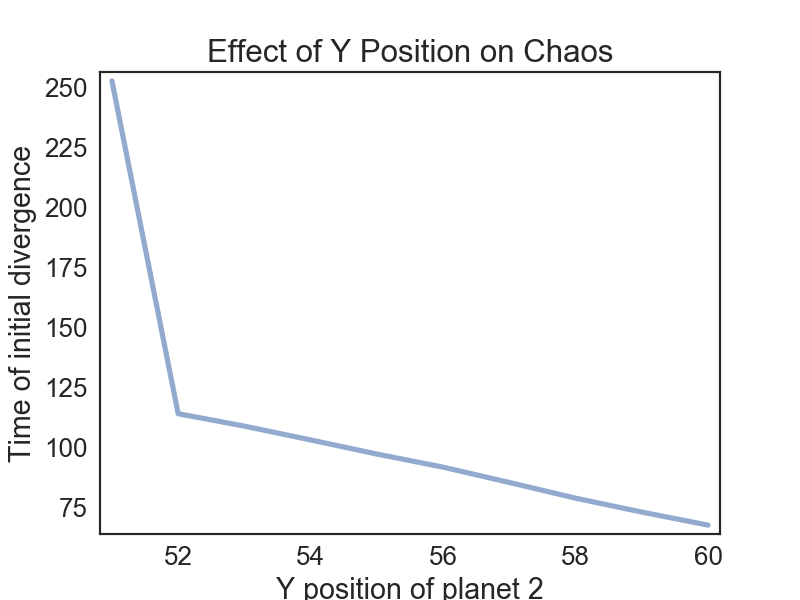

C:\ProgramData\Miniconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


In [27]:
newfig()
plot(y_p2Sweep)
decorate(xlabel='Y position of planet 2',
         ylabel='Time of initial divergence', title='Effect of Y Position on Chaos')

<IPython.core.display.Javascript object>


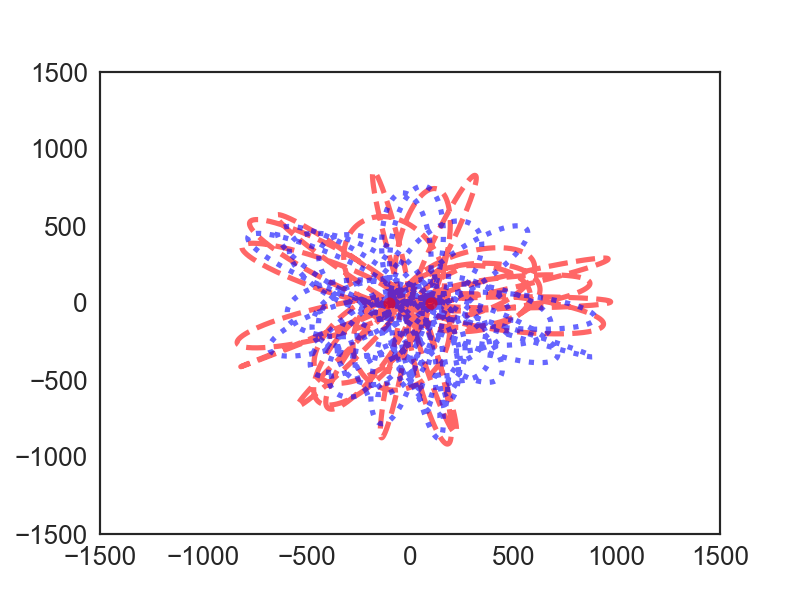

C:\ProgramData\Miniconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


In [12]:
newfig()
decorate(xlim = [-1500, 1500],
         ylim = [-1500, 1500],
         legend = True)
plot(system_2planet.results.x_p1, system_2planet.results.y_p1, 'r--', label = 'planet1')
plot(system_2planet.results.x_p2, system_2planet.results.y_p2, 'b:', label = 'planet2')
plot(-100, 0, 'ro')
plot(100, 0, 'ro')

In [ ]:
print(system_2planet.metric)

In [ ]:
print(system_2planet.results.index)

<IPython.core.display.Javascript object>


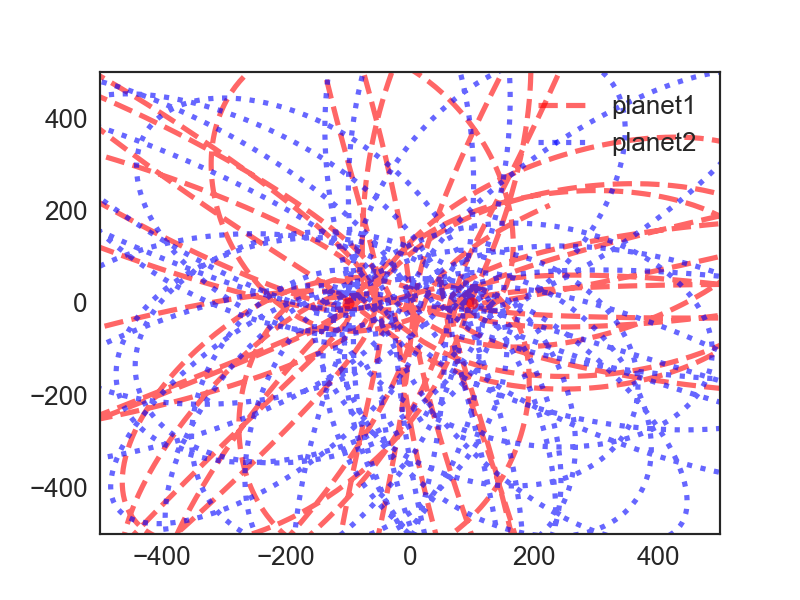

In [13]:
resampled_2planet = system_2planet.results.iloc[::5000, :]
newfig()
plot(resampled_2planet.x_p1, resampled_2planet.y_p1, 'r--', label = 'planet1')
plot(resampled_2planet.x_p2, resampled_2planet.y_p2, 'b:', label = 'planet2')
plot(-100, 0, 'ro')
plot(100, 0, 'ro')
decorate(xlim = [-500, 500],
         ylim = [-500, 500])

<IPython.core.display.Javascript object>


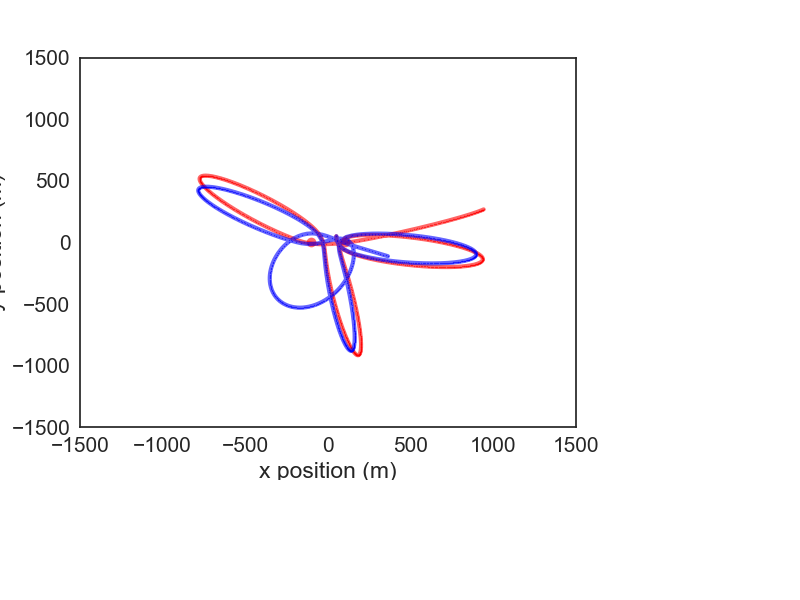

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


KeyboardInterrupt: 

In [15]:
newfig()
plot(-100, 0, 'ro')
plot(100, 0, 'ro')
decorate(xlabel='x position (m)',
         ylabel='y position (m)',
         xlim = [-1500, 1500],
         ylim =[-1500, 1500],
         legend=False)
x1_array = []
y1_array = []
x2_array = []
y2_array = []
for x1, y1, x2, y2, index in zip(resampled_2planet.x_p1, resampled_2planet.y_p1, resampled_2planet.x_p2, resampled_2planet.y_p2, resampled_2planet.index):
#     if index > system_2planet.metric:
#         print("diverge")
#         break
#     x1_array.append(x1)
#     y1_array.append(y1)
#     x2_array.append(x2)
#     y2_array.append(y2)
    plot(x1, y1, '-ro', markersize=1, update=False)
    plot(x2, y2, '-bo', markersize=1, update=False)
    #plot(x, y, '-o', update=True)
    #sleep(0.00001)

In [4]:
condition_2planets = Condition(m_s1 = 2 * 10**9,
                      m_s2 = 2 * 10**9,
                      m_p1 = 6 * 10**3,
                      m_p2 = 6 * 10**3,
                      G = 6.67*10**-5,
                      duration = 750,
                    #Minimun dt needed for accuracy varies depending on duration
                      dt = 0.0001)

In [5]:
def make_system_2planets(condition):
    """Make a system object.
    
    condition: Condition object with angle, velocity, x, y,
               diameter, duration, g, mass, rho, and C_d
               
    returns: System object
    """
    unpack(condition)
    
    # make the initial state
    init = State(x_s1=-100, y_s1=0, x_s2=100, y_s2=0, x_p1=50, y_p1=50, x_p2=50, y_p2=51,
                 vx_s1=0, vy_s1=0, vx_s2=0, vy_s2=0, vx_p1=0, vy_p1=-65, vx_p2=0, vy_p2=-65)
    
    # compute timestamps
    ts = linrange(0, duration, dt)
    
    return System(init=init, G = G, m_s1 = m_s1, m_s2 = m_s2, m_p1 = m_p1, m_p2 = m_p2, ts=ts, dt = dt, m_pnew = 0,
                  nevermores1 = 0, nevermores2 = 0, nevermores3 = 0, nevermores4 = 0, metric = duration, found_metric = 0, posp1 = [],
                  posp2 = [], x_p2_max = 400, check_distance = 15)

In [6]:
def slope_func_3(state, t, system):
    """Compute derivatives of the state.
    
    state: position, velocity
 n  m    t: time
    system: System object containing g, rho,
            C_d, area, and mass
    
    returns: derivatives of y and v
    """
    x_s1, y_s1, x_s2, y_s2, x_p1, y_p1, x_p2, y_p2, vx_s1, vy_s1, vx_s2, vy_s2, vx_p1, vy_p1, vx_p2, vy_p2 = state
    unpack(system)
    
    if x_p2 > x_p2_max:
        system.x_p2_max = x_p2
        system.check_distance = 15 * x_p2 / 400 * x_p2 / 400 
        
    if system.found_metric == 1:
        return 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
    
    check_distance = system.check_distance
    nevermores1 = system.nevermores1
    nevermores2 = system.nevermores2
    nevermores3 = system.nevermores3
    nevermores4 = system.nevermores4
    coll1 = 0
    coll2 = 0
    
    if nevermores1 == 1 or nevermores2 == 1 or nevermores3 == 1 or nevermores4 == 1:
        return 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
        
    pos_p1 = Vector(x_p1, y_p1)
    v_p1 = Vector(vx_p1, vy_p1)
    pos_p2 = Vector(x_p2, y_p2)
    v_p2 = Vector(vx_p2, vy_p2)
    pos_s1 = Vector(x_s1, y_s1)
    pos_s2 = Vector(x_s2, y_s2)
    
    system.posp1.append(pos_p1)
    system.posp2.append(pos_p2)
    
    if system.found_metric == 0:
        if pos_p1.dist(pos_p2) > check_distance:
            if abs(pos_p1.diff_angle(pos_p2)) > 0.1745329252: #10 degrees
                dis1 = []
                dis2 = []
                for p1, p2 in zip(system.posp1, system.posp2):
                    dis1.append(pos_p1.dist(p2))
                    dis2.append(pos_p2.dist(p1))
                min_dis1 = sorted(dis1)[0]
                min_dis2 = sorted(dis2)[0]
                if (min_dis1 > check_distance and min_dis2 > check_distance):
                    print("diverged")
                    system.found_metric = 1
                    system.metric = t
    
    if ((x_p1 - x_s1)**2 + (y_p1 - y_s1)**2) < (20**2): 
        if nevermores1 == 0:
            print("collision between p1 and sun1")
            system.nevermores1 = 1
            system.metric = t
        coll1 = 1
        F_p1s1 = Vector(0,0)
        F_p1s2 = Vector(0,0)
        
    else:
        if (coll1 == 0):
            system.nevermores1 = 0
            distance_p1s1 = pos_s1 - pos_p1
            F_p1s1 = (G * m_s1 * (m_p1 + m_pnew) / (distance_p1s1.mag**2)) * distance_p1s1.hat()
        

    if ((x_p1 - x_s2)**2 + (y_p1 - y_s2)**2) < (20**2):
        if nevermores2 == 0:
            print("collision between p1 and sun2")
            system.nevermores2 = 1
            system.metric = t
        coll1 = 1
        F_p1s1 = Vector(0,0)
        F_p1s2 = Vector(0,0)
        
    else:
        if (coll1 == 0):
            system.nevermores2 = 0
            distance_p1s2 = pos_s2 - pos_p1
            F_p1s2 = (G * m_s2 * (m_p1 + m_pnew) / (distance_p1s2.mag**2)) * distance_p1s2.hat()
            
    if ((x_p2 - x_s1)**2 + (y_p2 - y_s1)**2) < (20**2): 
        if nevermores3 == 0:
            print("collision between p2 and sun1")
            system.nevermores3 = 1
            system.metric = t
        coll2 = 1
        F_p2s1 = Vector(0,0)
        F_p2s2 = Vector(0,0)
        
    else:
        if (coll2 == 0):
            system.nevermores3 = 0
            distance_p2s1 = pos_s1 - pos_p2
            F_p2s1 = (G * m_s1 * (m_p2 + m_pnew) / (distance_p2s1.mag**2)) * distance_p2s1.hat()
            
    if ((x_p2 - x_s2)**2 + (y_p2 - y_s2)**2) < (20**2): 
        if nevermores4 == 0:
            print("collision between p2 and sun2")
            system.nevermores4 = 1
            system.metric = t
        coll2 = 1
        F_p2s1 = Vector(0,0)
        F_p2s2 = Vector(0,0)
        
    else:
        if (coll2 == 0):
            system.nevermores4 = 0
            distance_p2s2 = pos_s2 - pos_p2
            F_p2s2 = (G * m_s2 * (m_p2 + m_pnew) / (distance_p2s2.mag**2)) * distance_p2s2.hat()
    
    a_p1s1 = F_p1s1 / m_p1
    a_p1s2 = F_p1s2 / m_p1
    a_p1 = a_p1s1 + a_p1s2
    a_p1 = Vector(a_p1)

    a_p2s1 = F_p2s1 / m_p2
    a_p2s2 = F_p2s2 / m_p2
    a_p2 = a_p2s1 + a_p2s2
    a_p2 = Vector(a_p2)
    
    p_present_p1 = v_p1 * m_p1
    p_p1s1 = F_p1s1 * dt
    p_p1s2 = F_p1s2 * dt
    p_total_p1 = p_present_p1+p_p1s1+p_p1s2
    
    p_present_p2 = v_p2 * m_p1
    p_p2s1 = F_p2s1 * dt
    p_p2s2 = F_p2s2 * dt
    p_total_p2 = p_present_p2+p_p2s1+p_p2s2
    
    v_p1 = p_total_p1 / m_p1
    v_p1 = Vector(v_p1)
    v_p2 = p_total_p2 / m_p2
    v_p2 = Vector(v_p2)
    
    return 0, 0, 0, 0, v_p1.x, v_p1.y, v_p2.x, v_p2.y, 0, 0, 0, 0, a_p1.x, a_p1.y, a_p2.x, a_p2.y

In [5]:
system_2planet = make_system_2planets(condition_2planets)
%time run_odeint(system_2planet, slope_func_3)

KeyboardInterrupt: 

In [59]:
print(system_2planet.metric)

371.26456801642485


In [26]:
a = sorted(system_2planet.results.x_p2)
a[-1]

445.35881547675052

<IPython.core.display.Javascript object>


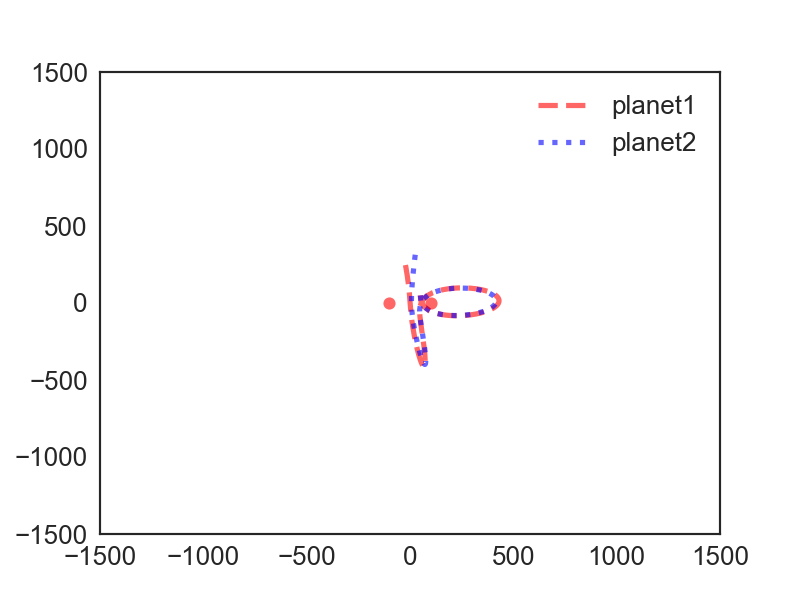

In [12]:
resampled_2planet = system_2planet.results.iloc[::5000, :]
newfig()
plot(resampled_2planet.x_p1, resampled_2planet.y_p1, 'r--', label = 'planet1')
plot(resampled_2planet.x_p2, resampled_2planet.y_p2, 'b:', label = 'planet2')
plot(-100, 0, 'ro')
plot(100, 0, 'ro')
decorate(xlim = [-1500, 1500],
         ylim = [-1500, 1500])

<IPython.core.display.Javascript object>


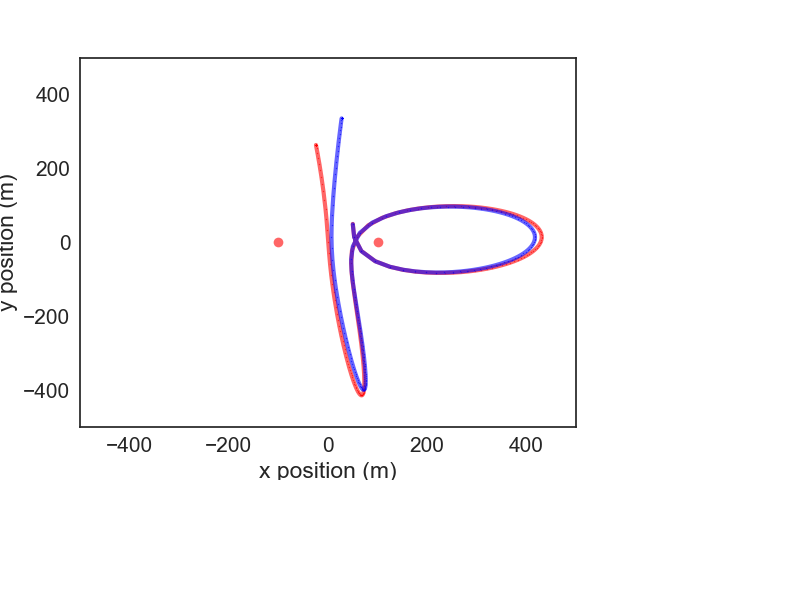

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit

KeyboardInterrupt: 

In [14]:
newfig()
plot(-100, 0, 'ro')
plot(100, 0, 'ro')
decorate(xlabel='x position (m)',
         ylabel='y position (m)',
         xlim = [-500, 500],
         ylim =[-500, 500],
         legend=False)
x1_array = []
y1_array = []
x2_array = []
y2_array = []
for x1, y1, x2, y2, index in zip(resampled_2planet.x_p1, resampled_2planet.y_p1, resampled_2planet.x_p2, resampled_2planet.y_p2, resampled_2planet.index):
#     if index > system_2planet.metric:
#         print("diverge")
#         break
#     x1_array.append(x1)
#     y1_array.append(y1)
#     x2_array.append(x2)
#     y2_array.append(y2)
    plot(x1, y1, '-ro', markersize=1, update=False)
    plot(x2, y2, '-bo', markersize=1, update=False)
    #plot(x, y, '-o', update=True)
    #sleep(0.00001)

In [16]:
resampled_2planet.y_p2

0.0       49.000000
0.5       13.816454
1.0      -23.812736
1.5      -51.121031
2.0      -65.943862
2.5      -74.010335
3.0      -78.449885
3.5      -80.699778
4.0      -81.496886
4.5      -81.262814
5.0      -80.260241
5.5      -78.663845
6.0      -76.595824
6.5      -74.145188
7.0      -71.378936
7.5      -68.348900
8.0      -65.096119
8.5      -61.653736
9.0      -58.048995
9.5      -54.304639
10.0     -50.439919
10.5     -46.471345
11.0     -42.413242
11.5     -38.278181
12.0     -34.077310
12.5     -29.820617
13.0     -25.517141
13.5     -21.175140
14.0     -16.802231
14.5     -12.405510
            ...    
735.5    335.464683
736.0    335.464683
736.5    335.464683
737.0    335.464683
737.5    335.464683
738.0    335.464683
738.5    335.464683
739.0    335.464683
739.5    335.464683
740.0    335.464683
740.5    335.464683
741.0    335.464683
741.5    335.464683
742.0    335.464683
742.5    335.464683
743.0    335.464683
743.5    335.464683
744.0    335.464683
744.5    335.464683


In [7]:
y_p2s = linrange(51, 55, 1)
y_p2Sweep = SweepSeries()
for y_p2 in y_p2s:
    system_2planet = make_system_2planets(condition_2planets)
    system_2planet.init.y_p2 = y_p2
    run_odeint(system_2planet, slope_func_3)
    if system_2planet.found_metric == 1:
        y_p2Sweep[y_p2] = system_2planet.metric

diverged
diverged
diverged
diverged
diverged


<IPython.core.display.Javascript object>


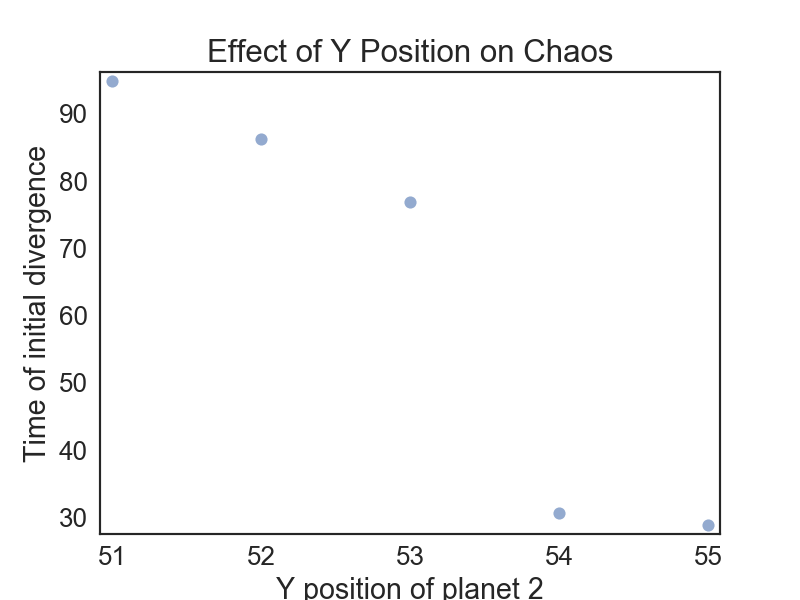

C:\ProgramData\Miniconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


In [8]:
newfig()
plot(y_p2Sweep, 'o')
decorate(xlabel='Y position of planet 2',
         ylabel='Time of initial divergence', title='Effect of Y Position on Chaos')

In [9]:
y_p2s_lower = linrange(45, 49, 1)
y_p2Sweep_lower = SweepSeries()
for y_p2 in y_p2s_lower:
    system_2planet = make_system_2planets(condition_2planets)
    system_2planet.init.y_p2 = y_p2
    run_odeint(system_2planet, slope_func_3)
    if system_2planet.found_metric == 1:
        y_p2Sweep_lower[y_p2] = system_2planet.metric

diverged
diverged
diverged
diverged
diverged


<IPython.core.display.Javascript object>


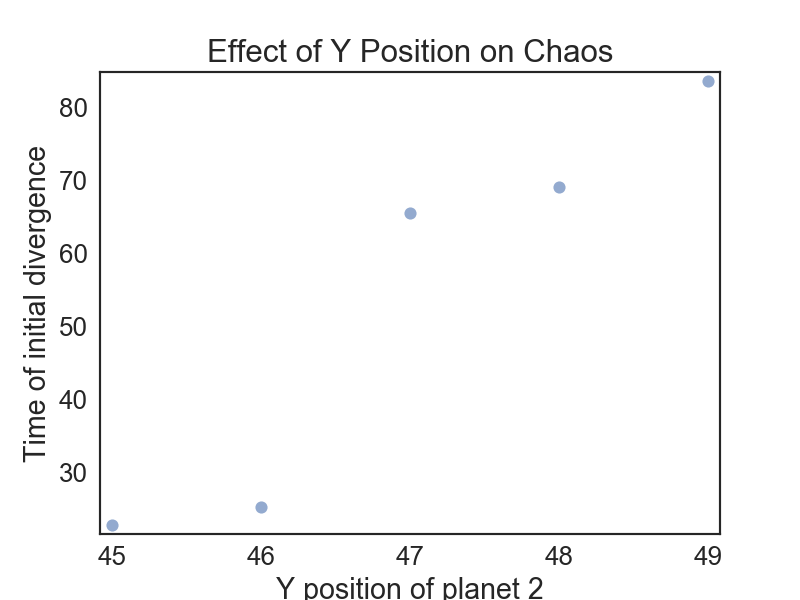

C:\ProgramData\Miniconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


In [10]:
newfig()
plot(y_p2Sweep_lower, 'o')
decorate(xlabel='Y position of planet 2',
         ylabel='Time of initial divergence', title='Effect of Y Position on Chaos')

<IPython.core.display.Javascript object>


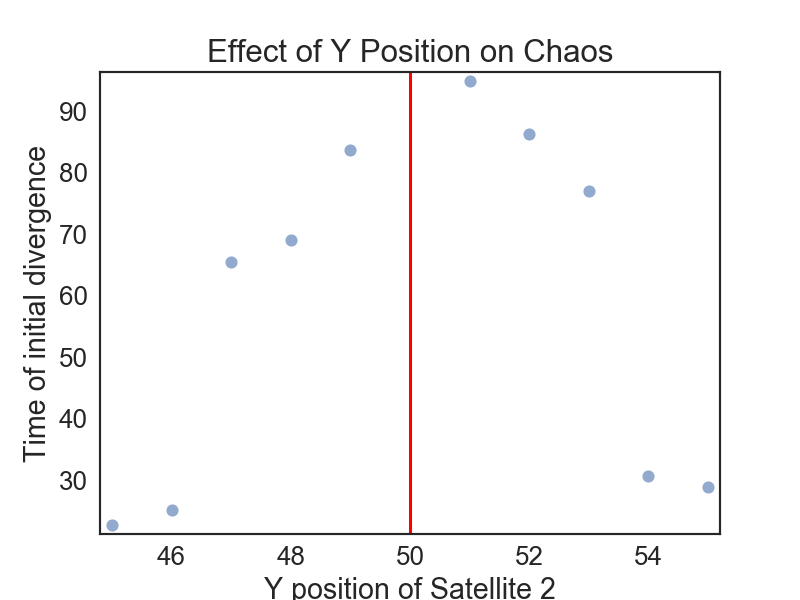

C:\ProgramData\Miniconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


In [19]:
newfig()
plot(y_p2Sweep_lower, 'o')
plot(y_p2Sweep, 'o')
plt.axvline(x=50, Color='r')
decorate(xlabel='Y position of Satellite 2',
         ylabel='Time of initial divergence', title='Effect of Y Position on Chaos')

In [73]:
x_p2s_lower = linrange(45, 49, 1)
x_p2Sweep_lower = SweepSeries()
for x_p2 in x_p2s_lower:
    system_2planet = make_system_2planets(condition_2planets)
    system_2planet.init.x_p2 = x_p2
    run_odeint(system_2planet, slope_func_3)
    if system_2planet.found_metric == 1:
        x_p2Sweep_lower[x_p2] = system_2planet.metric

diverged
diverged
diverged
diverged
diverged


<IPython.core.display.Javascript object>


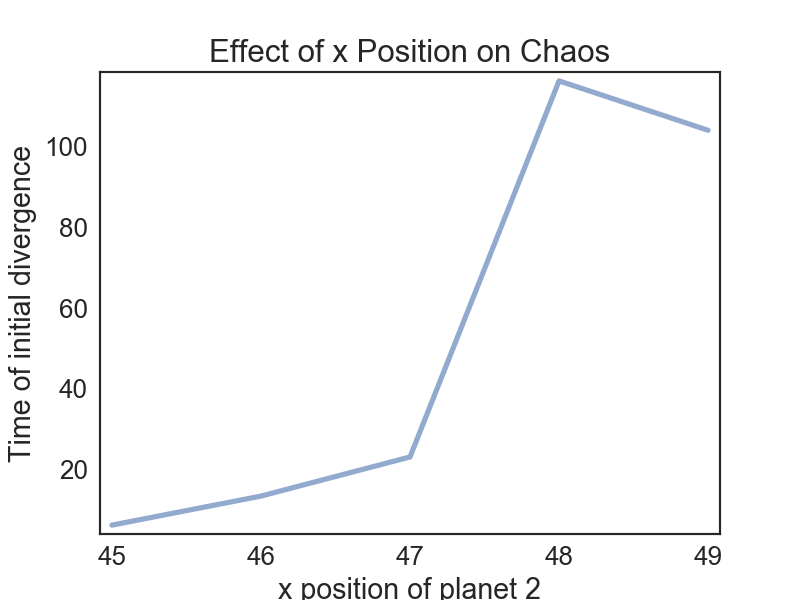

C:\ProgramData\Miniconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


In [74]:
newfig()
plot(x_p2Sweep_lower)
decorate(xlabel='x position of planet 2',
         ylabel='Time of initial divergence', title='Effect of x Position on Chaos')

In [78]:
x_p2s_higher = linrange(51, 55, 1)
x_p2Sweep_higher = SweepSeries()
for x_p2 in x_p2s_higher:
    system_2planet = make_system_2planets(condition_2planets)
    system_2planet.init.x_p2 = x_p2
    run_odeint(system_2planet, slope_func_3)
    if system_2planet.found_metric == 1:
        x_p2Sweep_higher[x_p2] = system_2planet.metric

diverged
diverged
diverged
diverged
diverged


<IPython.core.display.Javascript object>


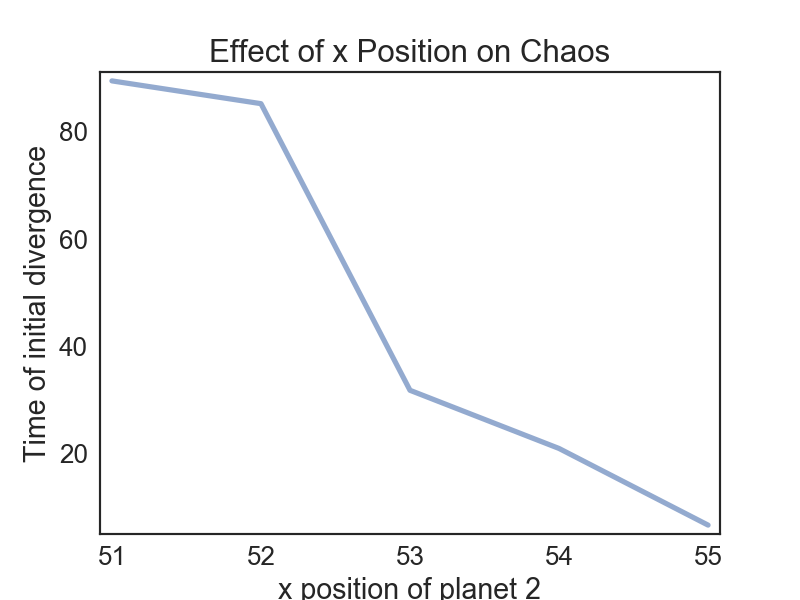

C:\ProgramData\Miniconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


In [79]:
newfig()
plot(x_p2Sweep_higher)
decorate(xlabel='x position of planet 2',
         ylabel='Time of initial divergence', title='Effect of x Position on Chaos')

In [76]:
vy_p2s_lower = linrange(-64, -60, 1)
vy_p2Sweep_lower = SweepSeries()
for vy_p2 in vy_p2s_lower:
    system_2planet = make_system_2planets(condition_2planets)
    system_2planet.init.vy_p2 = vy_p2
    run_odeint(system_2planet, slope_func_3)
    if system_2planet.found_metric == 1:
        vy_p2Sweep_lower[vy_p2] = system_2planet.metric

diverged
diverged
diverged
diverged
diverged


<IPython.core.display.Javascript object>


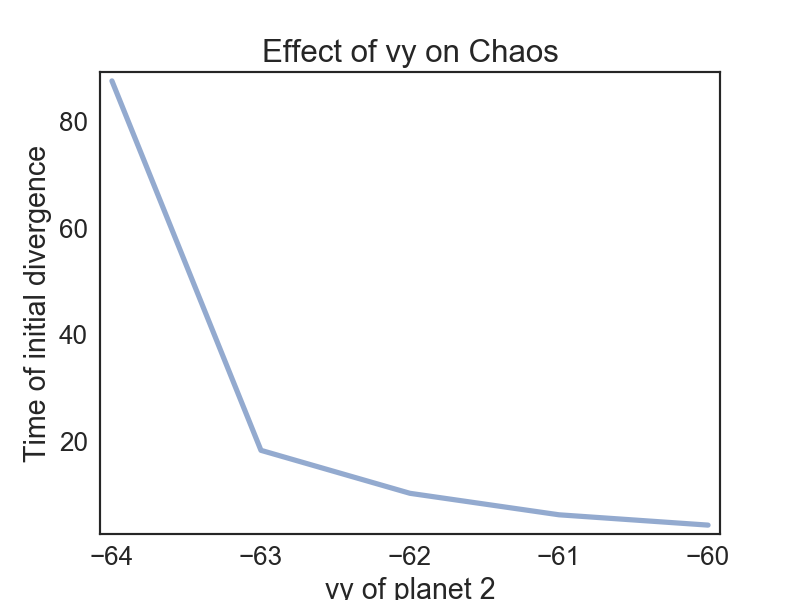

C:\ProgramData\Miniconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


In [77]:
newfig()
plot(vy_p2Sweep_lower)
decorate(xlabel='vy of planet 2',
         ylabel='Time of initial divergence', title='Effect of vy on Chaos')

In [80]:
vy_p2s_higher = linrange(-70, -66, 1)
vy_p2Sweep_higher = SweepSeries()
for vy_p2 in vy_p2s_higher:
    system_2planet = make_system_2planets(condition_2planets)
    system_2planet.init.vy_p2 = vy_p2
    run_odeint(system_2planet, slope_func_3)
    if system_2planet.found_metric == 1:
        vy_p2Sweep_higher[vy_p2] = system_2planet.metric

diverged
diverged
diverged
diverged
diverged


<IPython.core.display.Javascript object>


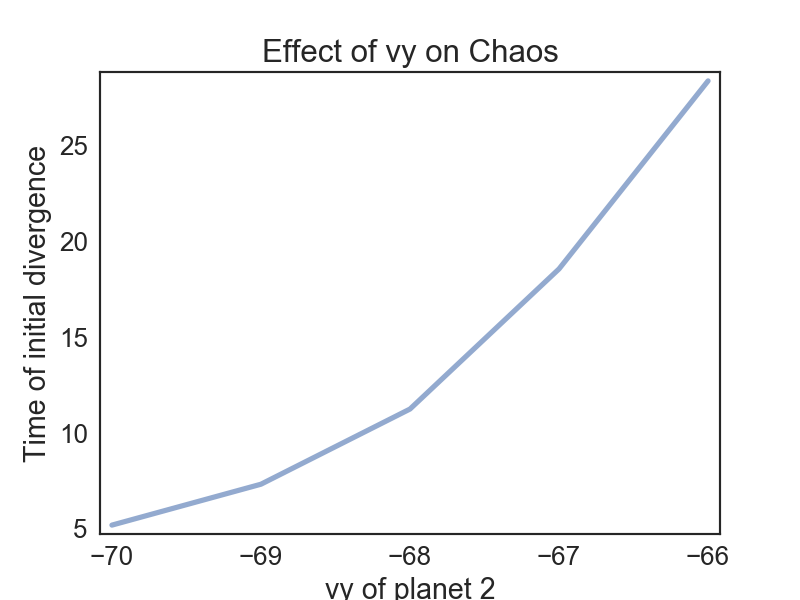

C:\ProgramData\Miniconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


In [82]:
newfig()
plot(vy_p2Sweep_higher)
decorate(xlabel='vy of planet 2',
         ylabel='Time of initial divergence', title='Effect of vy on Chaos')

In [6]:
vx_p2s_lower = linrange(-10, -1, .1)
vx_p2Sweep_lower = SweepSeries()
for vx_p2 in vx_p2s_lower:
    system_2planet = make_system_2planets(condition_2planets)
    system_2planet.init.vx_p2 = vx_p2
    run_odeint(system_2planet, slope_func_3)
    if system_2planet.found_metric == 1:
        vx_p2Sweep_lower[vx_p2] = system_2planet.metric

diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged


<IPython.core.display.Javascript object>


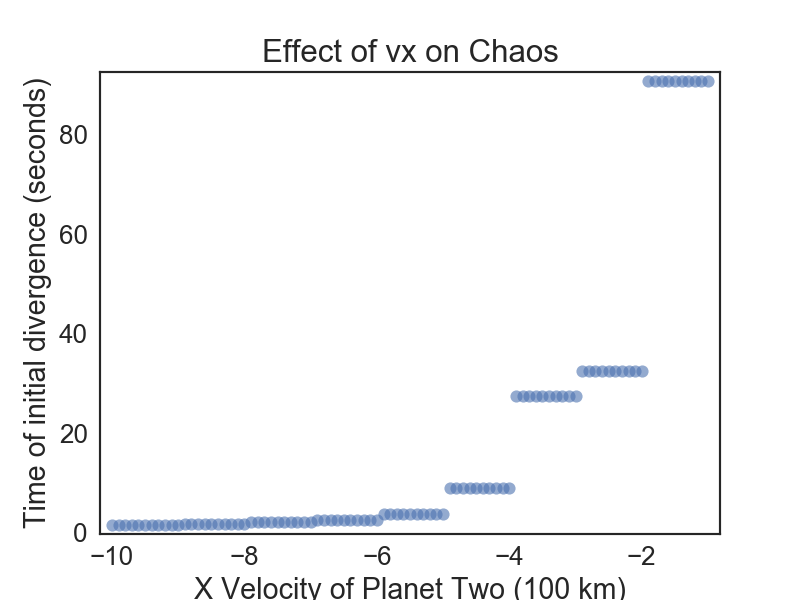

C:\ProgramData\Miniconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


In [10]:
newfig()
plot(vx_p2Sweep_lower, 'o')
decorate(xlabel='X Velocity of Planet Two (100 km)',
         ylabel='Time of initial divergence (seconds)', title='Effect of vx on Chaos')

In [25]:
vx_p2Sweep_lower.iloc[::1]

,value
-10.0,1.516778
-9.9,1.625638
-9.8,1.625638
-9.7,1.625638
-9.6,1.625638
-9.5,1.625638
-9.4,1.625638
-9.3,1.625638
-9.2,1.625638
-9.1,1.625638


In [8]:
vx_p2s_higher = linrange(1, 10, .1)
vx_p2Sweep_higher = SweepSeries()
for vx_p2 in vx_p2s_higher:
    system_2planet = make_system_2planets(condition_2planets)
    system_2planet.init.vx_p2 = vx_p2
    run_odeint(system_2planet, slope_func_3)
    if system_2planet.found_metric == 1:
        vx_p2Sweep_higher[vx_p2] = system_2planet.metric

diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged
diverged


<IPython.core.display.Javascript object>


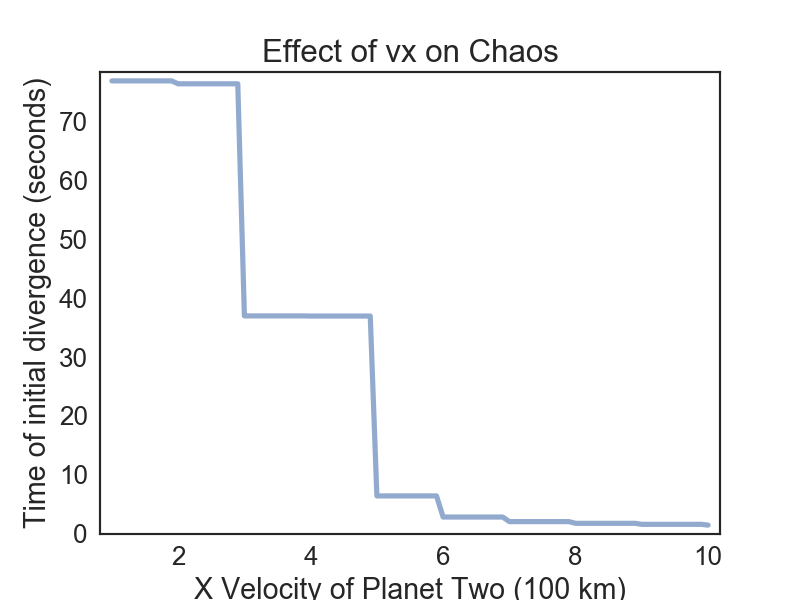

C:\ProgramData\Miniconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


In [9]:
newfig()
plot(vx_p2Sweep_higher)
decorate(xlabel='X Velocity of Planet Two (100 km/s)',
         ylabel='Time of initial divergence (seconds)', title='Effect of vx on Chaos')

In [21]:
vx_p2Sweep_higher.iloc[::5]

1.0     76.907172
1.5     76.907172
2.0     76.410232
2.5     76.410232
3.0     36.991290
3.5     36.991290
4.0     36.965513
4.5     36.965513
5.0      6.417542
5.5      6.417542
6.0      2.832376
6.5      2.832376
7.0      2.051577
7.5      2.051577
8.0      1.761759
8.5      1.761759
9.0      1.591216
9.5      1.591216
10.0     1.459012
dtype: float64

In [88]:
m_p2s_higher = linrange(6.01, 6.05, 0.01)
m_p2Sweep_higher = SweepSeries()
for m_p2 in m_p2s_higher:
    system_2planet = make_system_2planets(condition_2planets)
    system_2planet.m_p2 = m_p2*10**3
    run_odeint(system_2planet, slope_func_3)
    if system_2planet.found_metric == 1:
        m_p2Sweep_higher[m_p2] = system_2planet.metric

diverged
diverged
diverged
diverged
diverged


<IPython.core.display.Javascript object>


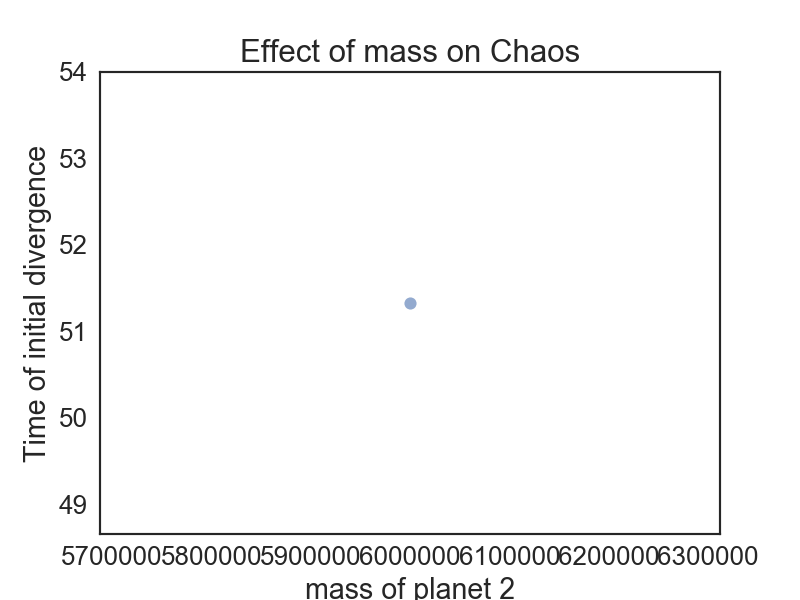

C:\ProgramData\Miniconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


In [89]:
newfig()
plot(m_p2Sweep_higher, 'o')
decorate(xlabel='mass of planet 2',
         ylabel='Time of initial divergence', title='Effect of mass on Chaos')

In [99]:
m_p2s_lower = linrange(5.95, 5.99, 0.01)
m_p2Sweep_lower = SweepSeries()
for m_p2 in m_p2s_lower:
    system_2planet = make_system_2planets(condition_2planets)
    system_2planet.m_p2 = m_p2*10**3
    run_odeint(system_2planet, slope_func_3)
    if system_2planet.found_metric == 1:
        m_p2Sweep_higher[m_p2] = system_2planet.metric

diverged
diverged
diverged
diverged
diverged


<IPython.core.display.Javascript object>


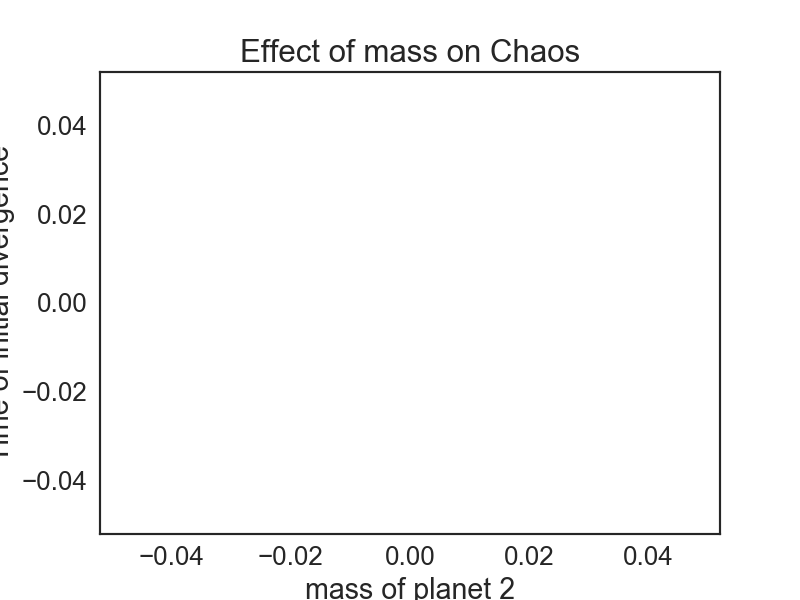

C:\ProgramData\Miniconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


In [100]:
newfig()
plot(m_p2Sweep_lower)
decorate(xlabel='mass of planet 2',
         ylabel='Time of initial divergence', title='Effect of mass on Chaos')

In [101]:
m_p2Sweep_lower

,value
